In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image, ImageOps
import time
import torch.nn as nn
# %matplotlib inline
import os
import torch
from torch.autograd import Variable
import math
from skimage.measure import compare_psnr
dtype = torch.cuda.FloatTensor

In [2]:
class Concat(nn.Module):
    def __init__(self, dim, skip, deeper):
        super(Concat, self).__init__()
        self.dim = dim
        self.layer1 = skip
        self.layer2 = deeper
    def forward(self, input):
        inputs = []
        inputs.append(self.layer1(input))
        inputs.append(self.layer2(input))
        return torch.cat(inputs, dim=self.dim)

def get_name(name):
    name[0] +=1
    return str(name[0])

def skip(c_in, c_out, c_down, c_up, c_skip, k_down, k_up, k_skip, upsample_mode):
    model = nn.Sequential()
    model_tmp = model
    input_depth = c_in
    name = [0]
    for i in range(len(c_down)):
        layer = nn.Sequential()
        layer.add_module(get_name(name),nn.Conv2d(input_depth, c_down[i], k_down, 2, padding=int((k_down - 1) / 2)))
        layer.add_module(get_name(name),nn.BatchNorm2d(c_down[i]))
        layer.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))

        layer.add_module(get_name(name),nn.Conv2d(c_down[i], c_down[i], k_down, 1, padding=int((k_down - 1) / 2)))
        layer.add_module(get_name(name),nn.BatchNorm2d(c_down[i]))
        layer.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))

        deeper_main = nn.Sequential()
        
        if i < len(c_down)-1:
            layer.add_module(get_name(name),deeper_main)
            layer.add_module(get_name(name),nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                concat_layers = []
                concat_layers.append(nn.Conv2d(input_depth, c_skip[i], k_skip, 1, padding=int((k_skip - 1) / 2)))
                concat_layers.append(nn.BatchNorm2d(c_skip[i]))
                concat_layers.append(nn.LeakyReLU(0.2, inplace=True))
                model_tmp.add_module(get_name(name),Concat(1, nn.Sequential(*concat_layers), layer))
            else:
                model_tmp.add_module(get_name(name),layer)
            model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_skip[i] + c_up[i + 1] ))
            model_tmp.add_module(get_name(name),nn.Conv2d(c_skip[i] + c_up[i + 1], c_up[i], k_up, 1, padding=int((k_up - 1) / 2)))
            
        else:#last layer
            layer.add_module(get_name(name),nn.Upsample(scale_factor=2, mode=upsample_mode))
            if c_skip[i] != 0:
                concat_layers = []
                concat_layers.append(nn.Conv2d(input_depth, c_skip[i], k_skip, 1, padding=int((k_skip - 1) / 2)))
                concat_layers.append(nn.BatchNorm2d(c_skip[i]))
                concat_layers.append(nn.LeakyReLU(0.2, inplace=True))
                model_tmp.add_module(get_name(name),Concat(1, nn.Sequential(*concat_layers), layer))
            else:
                model_tmp.add_module(get_name(name),layer)
            model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_skip[i] +c_down[i]))
            model_tmp.add_module(get_name(name),nn.Conv2d(c_skip[i] + c_down[i], c_up[i], k_up, 1, padding=int((k_up - 1) / 2)))

        model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_up[i]))
        model_tmp.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))
        model_tmp.add_module(get_name(name),nn.Conv2d(c_up[i], c_up[i], 1, 1))
        model_tmp.add_module(get_name(name),nn.BatchNorm2d(c_up[i]))
        model_tmp.add_module(get_name(name),nn.LeakyReLU(0.2, inplace=True))
        input_depth = c_down[i]
        model_tmp = deeper_main

    model.add_module(get_name(name),nn.Conv2d(c_up[0], c_out, 1, 1))
    model.add_module(get_name(name),nn.Sigmoid())

    return model

In [3]:
def preprocess_input_with_mask(img, mask):
    img = Image.open(img)
#     img.resize((512,512), Image.ANTIALIAS)
    img = ImageOps.fit(img, (512,512), Image.ANTIALIAS)
    plt.imshow(img)
    mask = Image.open(mask)
    plt.figure()
    plt.imshow(mask,cmap='gray')
    img = np.array(img).transpose(2,0,1)
    print(img.shape)
    img = img[:3,:512,:512]/255
    mask = np.array(mask)[None, :]/255
    processed_img = img*mask
    plt.figure()
    plt.imshow(processed_img.transpose(1,2,0))
#     img = (torch.from_numpy(img)[None,:]).type(dtype)
    mask = (torch.from_numpy(mask)[None,:]).type(dtype)
    processed_img = (torch.from_numpy(processed_img)[None,:]).type(dtype)
    return img, mask, processed_img 

In [4]:
def preprocess_input(img):
    img = Image.open(img)
#     img.resize((512,512), Image.ANTIALIAS)
    img = ImageOps.fit(img, (512,512), Image.ANTIALIAS)
    plt.imshow(img)
    img = np.array(img)
    print(img.shape)
    
    tmp = np.random.choice(512*512, 512*512//2)
    processed_img = img.copy()
    
    if len(img.shape)<3:
        
        img = img[:512,:512]/255
        mask = np.ones((512,512))
        for i in tmp:
            mask[i//512,i%512] = 0
        plt.figure()
        plt.imshow(mask, cmap='gray')
        
        processed_img = img*mask
        
        plt.figure()
        plt.imshow(processed_img)
        
    else:
        img = np.array(img).transpose(2,0,1)
        img = img[:3,:512,:512]/255
        mask = np.ones((3,512,512))
        for i in tmp:
            mask[:,i//512,i%512] = 0
        plt.figure()
        plt.imshow(mask.transpose(1,2,0))
        
        processed_img = img*mask
    
        plt.figure()
        plt.imshow(processed_img.transpose(1,2,0))

    mask = (torch.from_numpy(mask)[None,:]).type(dtype)
    processed_img = (torch.from_numpy(processed_img)[None,:]).type(dtype)
    return img, mask, processed_img 

(4, 512, 512)


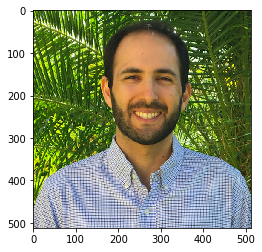

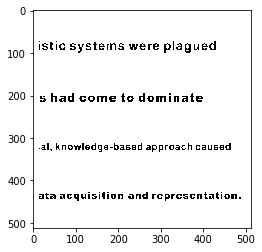

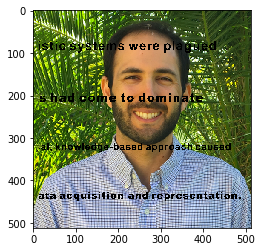

In [43]:
base_dir = 'inpainting_dataset/'
img = base_dir+'justin.png'
mask = base_dir+'justin_mask.png'
img, mask, processed_img = preprocess_input_with_mask(img, mask)

/home/yujiaq3/venv_python3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


Op time: 0.112086
Iteration 00000  Loss 0.063766  PSNR 9.793834
3


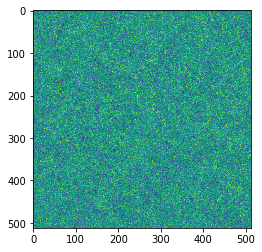

Op time: 9.661742
Iteration 00100  Loss 0.004830  PSNR 20.941905
3


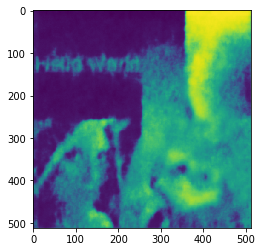

Op time: 19.398887
Iteration 00200  Loss 0.001694  PSNR 25.437072
3


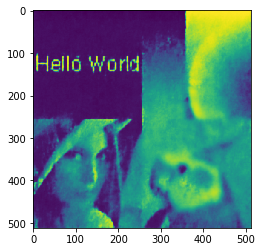

Op time: 29.060128
Iteration 00300  Loss 0.000896  PSNR 28.166539
3


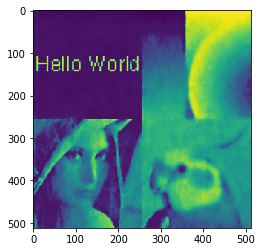

Op time: 38.608365
Iteration 00400  Loss 0.000674  PSNR 29.398364
3


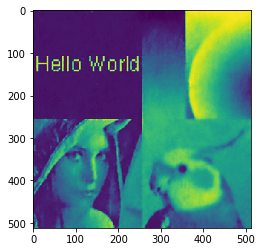

Op time: 48.038690
Iteration 00500  Loss 0.000474  PSNR 30.875680
3


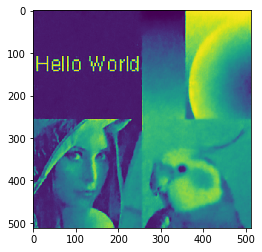

Op time: 57.580329
Iteration 00600  Loss 0.000372  PSNR 31.903940
3


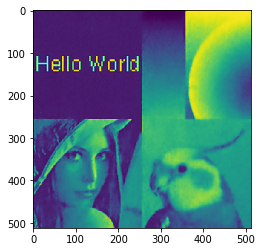

Op time: 67.188934
Iteration 00700  Loss 0.000315  PSNR 32.612756
3


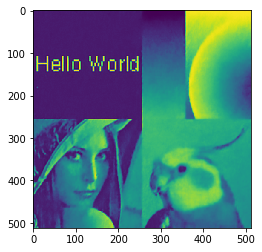

Op time: 76.762166
Iteration 00800  Loss 0.000277  PSNR 33.169735
3


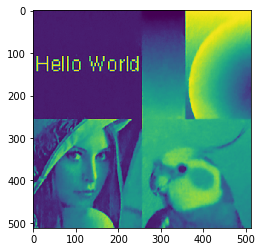

Op time: 86.287619
Iteration 00900  Loss 0.000242  PSNR 33.747026
3


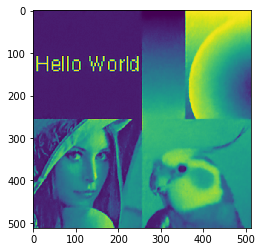

Op time: 95.906943
Iteration 01000  Loss 0.000204  PSNR 34.486200
3


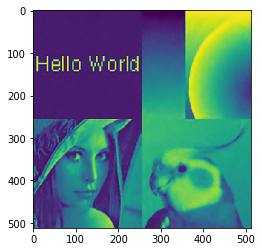

Op time: 105.928197
Iteration 01100  Loss 0.000183  PSNR 34.921237
3


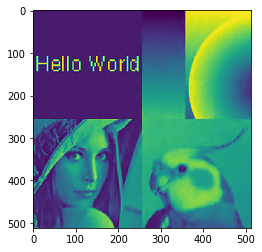

Op time: 115.707591
Iteration 01200  Loss 0.000166  PSNR 35.374604
3


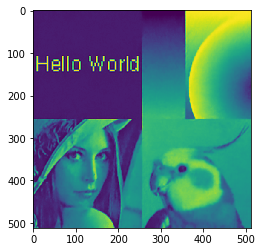

Op time: 125.586150
Iteration 01300  Loss 0.000163  PSNR 35.428261
3


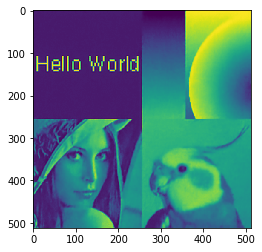

Op time: 135.078009
Iteration 01400  Loss 0.000129  PSNR 36.409092
3


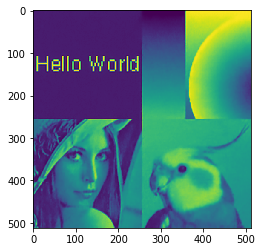

Op time: 144.486141
Iteration 01500  Loss 0.000125  PSNR 36.527241
3


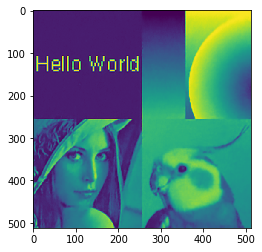

Op time: 154.205957
Iteration 01600  Loss 0.000127  PSNR 36.494786
3


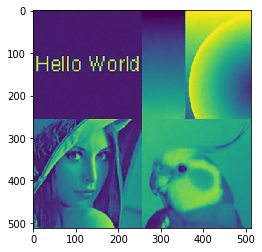

Op time: 163.630800
Iteration 01700  Loss 0.000108  PSNR 37.173755
3


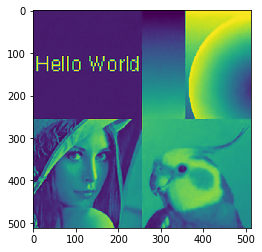

Op time: 173.244740
Iteration 01800  Loss 0.000096  PSNR 37.669906
3


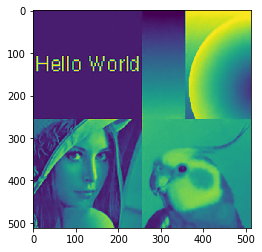

Op time: 182.955767
Iteration 01900  Loss 0.000099  PSNR 37.556853
3


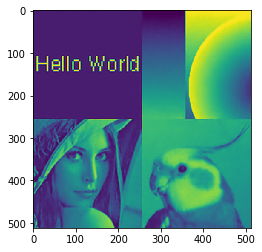

Op time: 192.314415
Iteration 02000  Loss 0.000085  PSNR 38.173536
3


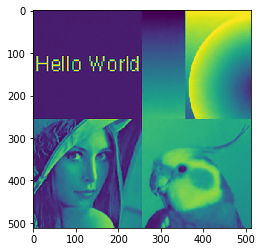

Op time: 201.679426
Iteration 02100  Loss 0.000085  PSNR 38.140142
3


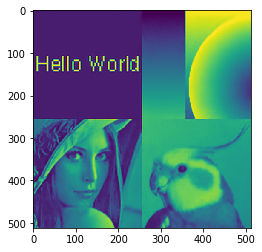

Op time: 211.289135
Iteration 02200  Loss 0.000082  PSNR 38.339325
3


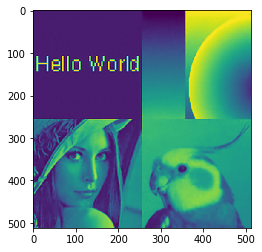

Op time: 220.771377
Iteration 02300  Loss 0.000078  PSNR 38.538426
3


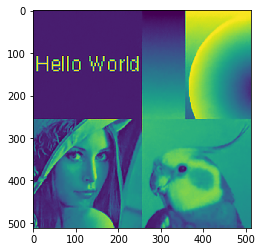

Op time: 230.532442
Iteration 02400  Loss 0.000079  PSNR 38.552781
3


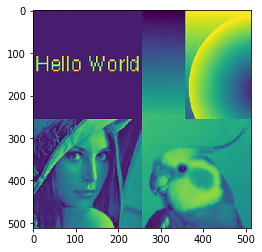

Op time: 240.080807
Iteration 02500  Loss 0.000069  PSNR 39.009509
3


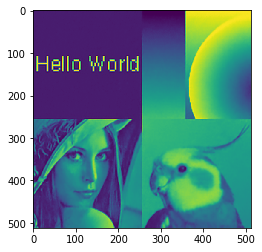

Op time: 249.755073
Iteration 02600  Loss 0.000068  PSNR 39.108866
3


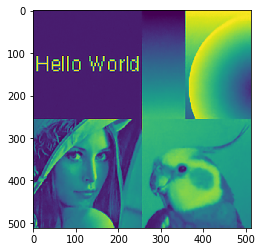

Op time: 259.424511
Iteration 02700  Loss 0.000066  PSNR 39.248876
3


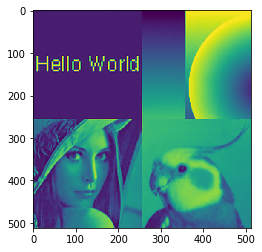

Op time: 269.297390
Iteration 02800  Loss 0.000055  PSNR 40.006887
3


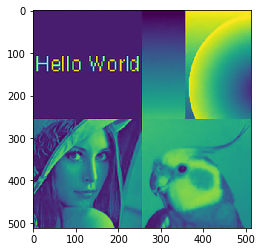

Op time: 278.892823
Iteration 02900  Loss 0.000056  PSNR 39.916016
3


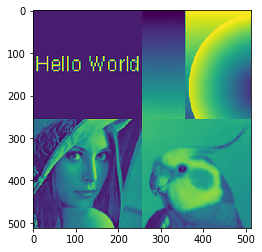

Op time: 288.815913
Iteration 03000  Loss 0.000053  PSNR 40.175936
3


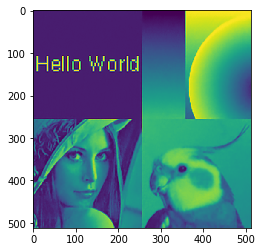

Op time: 298.523673
Iteration 03100  Loss 0.000052  PSNR 40.222782
3


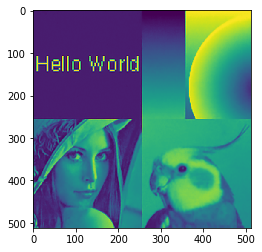

Op time: 308.557724
Iteration 03200  Loss 0.000046  PSNR 40.703256
3


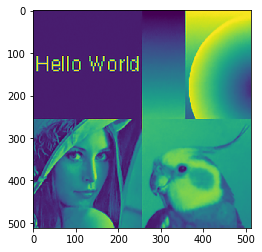

Op time: 318.253211
Iteration 03300  Loss 0.000043  PSNR 41.045398
3


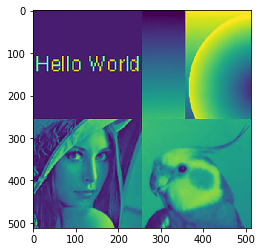

Op time: 328.087632
Iteration 03400  Loss 0.000043  PSNR 41.005045
3


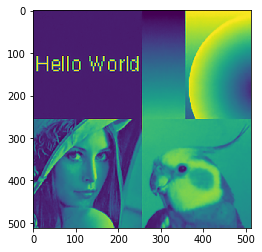

Op time: 337.667457
Iteration 03500  Loss 0.000054  PSNR 40.122391
3


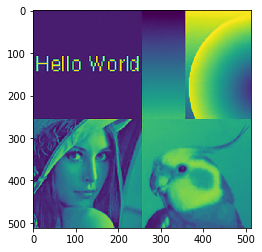

Op time: 347.207765
Iteration 03600  Loss 0.013305  PSNR 16.583248
3


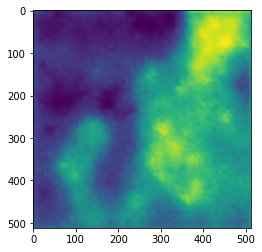

Op time: 356.898388
Iteration 03700  Loss 0.007660  PSNR 18.979177
3


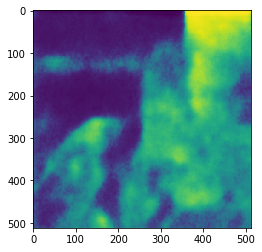

Op time: 366.436254
Iteration 03800  Loss 0.005383  PSNR 20.463483
3


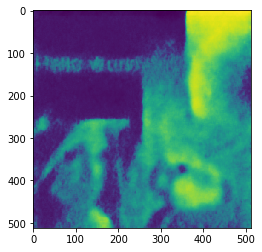

Op time: 376.090330
Iteration 03900  Loss 0.002974  PSNR 22.987919
3


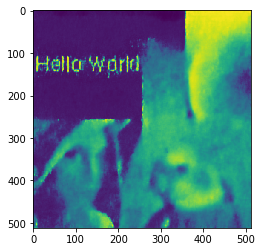

Op time: 385.808831
Iteration 04000  Loss 0.001846  PSNR 25.047959
3


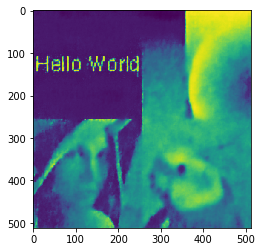

Op time: 395.339780
Iteration 04100  Loss 0.001371  PSNR 26.367812
3


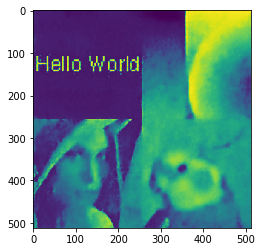

Op time: 404.975812
Iteration 04200  Loss 0.000999  PSNR 27.731445
3


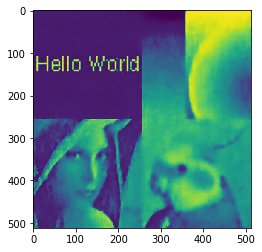

Op time: 415.226691
Iteration 04300  Loss 0.000836  PSNR 28.451604
3


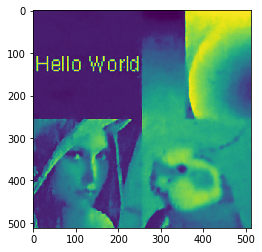

Op time: 425.002514
Iteration 04400  Loss 0.000738  PSNR 29.052382
3


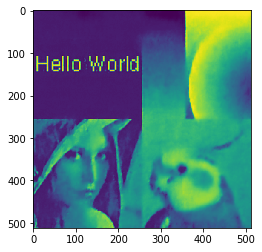

Op time: 435.908708
Iteration 04500  Loss 0.000573  PSNR 30.101382
3


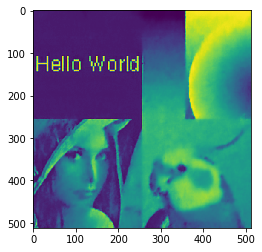

Op time: 445.557864
Iteration 04600  Loss 0.000498  PSNR 30.693176
3


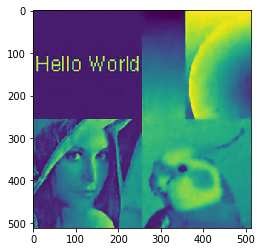

Op time: 455.391724
Iteration 04700  Loss 0.000433  PSNR 31.288684
3


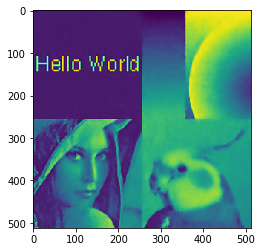

Op time: 465.094556
Iteration 04800  Loss 0.000397  PSNR 31.632888
3


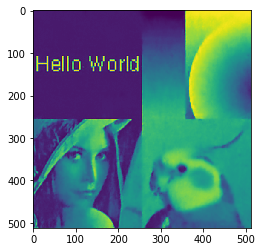

Op time: 474.610569
Iteration 04900  Loss 0.000357  PSNR 32.074413
3


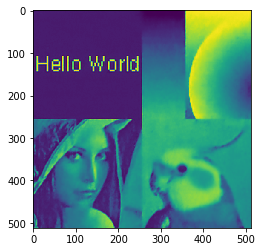

Op time: 484.156235
Iteration 05000  Loss 0.000313  PSNR 32.642934
3


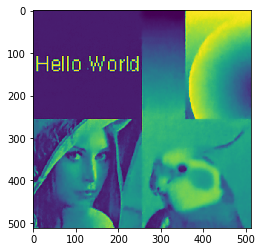

Op time: 494.157756
Iteration 05100  Loss 0.000296  PSNR 32.860544
3


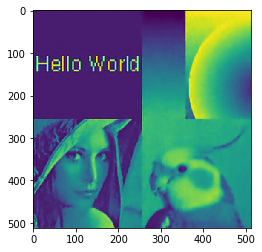

Op time: 503.915417
Iteration 05200  Loss 0.000251  PSNR 33.525836
3


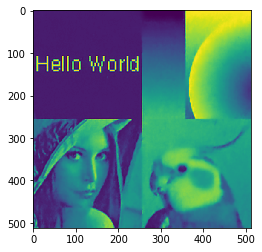

Op time: 513.892833
Iteration 05300  Loss 0.000243  PSNR 33.722795
3


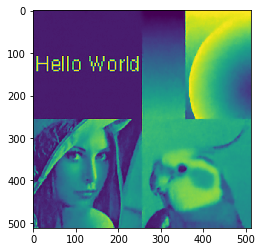

Op time: 524.338164
Iteration 05400  Loss 0.000220  PSNR 34.140579
3


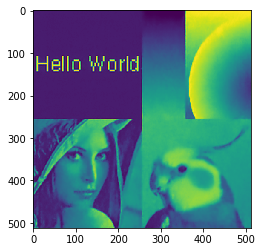

Op time: 534.360862
Iteration 05500  Loss 0.000211  PSNR 34.339634
3


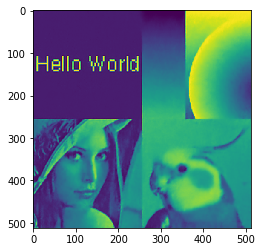

Op time: 546.477357
Iteration 05600  Loss 0.000280  PSNR 33.163127
3


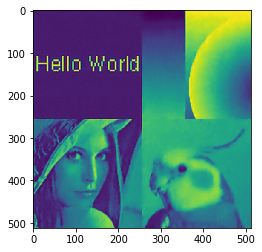

Op time: 556.664691
Iteration 05700  Loss 0.000194  PSNR 34.658984
3


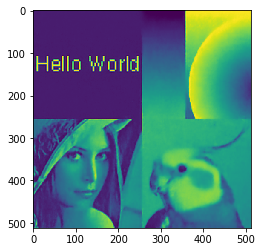

Op time: 567.358894
Iteration 05800  Loss 0.000189  PSNR 34.803092
3


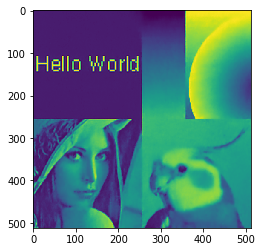

Op time: 577.483142
Iteration 05900  Loss 0.000166  PSNR 35.336276
3


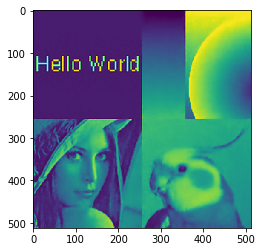

Op time: 587.144268
Iteration 06000  Loss 0.000162  PSNR 35.414341
3


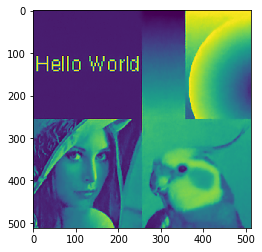

Op time: 587.416323


In [37]:
input_depth = 32
LR = 0.01 
num_iter = 6001
reg_noise_std = 0.03
if len(processed_img.shape)<4:
    c = 1
    w,h = processed_img.shape[1],processed_img.shape[2]
else:
    c = processed_img.shape[1]
    w,h = processed_img.shape[2], processed_img.shape[3]
    

model = skip(input_depth, c, 
               c_down = [128] * 5,
               c_up =   [128] * 5,
               c_skip =    [128] * 5,  
               k_up = 3, k_down = 3, 
               upsample_mode='nearest', k_skip=1).type(dtype)
# print(model)

mse = torch.nn.MSELoss().type(dtype)

net_input = torch.zeros([1, input_depth, w, h])
net_input = net_input.type(dtype)
net_input.uniform_() #net_input.normal_()
net_input *= 0.1           
noise = net_input.detach().clone()
net_input_saved = net_input.detach().clone()

params = [x for x in model.parameters()]
optimizer = torch.optim.Adam(params, lr=LR)
PSNR = []
start = time.time()
for i in range(num_iter):
    optimizer.zero_grad()
    
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = model(net_input)

    loss = mse(out * mask, processed_img)
    loss.backward()
    
    optimizer.step()
    out = out.detach().cpu().numpy()[0]
    if len(img.shape)>2:
        psnr = compare_psnr(img, out)
        PSNR.append(psnr)
    else:
        psnr = compare_psnr(img, out[0])
        PSNR.append(psnr)

    if i % 100 == 0:
        print("Op time: %f" % (time.time()-start))
        print('Iteration %05d  Loss %f  PSNR %f' % (i, loss.item(), psnr))
        plt.figure()
        print(len(out.shape))
        if len(img.shape)<3:
            plt.imshow(out[0])
        else:
            plt.imshow(out.transpose(1,2,0))
        plt.show()
print("Op time: %f" % (time.time()-start))

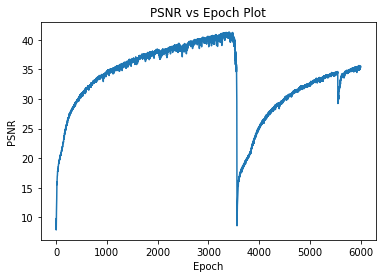

In [38]:
plt.title("PSNR vs Epoch Plot")
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.plot(PSNR)

In [39]:
max(PSNR)

41.28234809039515